# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "TRKNN"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'TRKNN',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_016  Q8NBI6                     15.357
Sample_114  P68036;P68036-2;P68036-3   14.011
Sample_019  P35858;P35858-2            18.089
Sample_204  P62937                     17.573
Sample_037  Q16769                     18.555
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by TRKNN: runs/alzheimer_study/preds/pred_real_na_TRKNN.csv


Sample ID   protein groups
Sample_179  P69892           15.288
Sample_050  H3BRV9;P61970    16.752
Sample_196  Q9C0C4           14.328
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.384
            A0A075B6Q5                 12.641
            A0A075B6R2                 13.404
            A0A075B6S5                 12.503
            A0A087WSY4                 13.927
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.045
            Q9UI40;Q9UI40-2            12.807
            Q9UIW2                     12.271
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.606
            Q9UP79                     11.069
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.770,15.050,16.842,19.863,15.931,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.954,19.067,...,15.528,15.576,13.938,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.006,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,16.035,17.705,17.039,15.261,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.820,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.543,15.345,17.084,18.708,14.249,19.433,12.319,11.307
Sample_207,15.739,16.877,15.469,16.898,15.779,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.222,13.729,12.623,13.391,12.678,14.735,12.909,12.833,11.781,12.826
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.480,19.067,16.127,...,15.173,13.636,13.065,12.890,13.222,11.745,13.821,12.915,12.555,13.531
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.600,13.111,13.022,12.425,12.021,14.138,13.165,13.012,12.164,12.029
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.927,12.504,12.415,14.445,13.312,12.113,12.992,12.358,13.320,13.580
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.633,12.513,11.887,11.960,13.102,11.663,12.356,12.690,12.419,12.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.268,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 327.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]

100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.47it/s]

100%|██████████| 4/4 [00:00<00:00,  5.64it/s]

100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.75it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.22it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.23it/s]

100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.14it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.43it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.13it/s]

100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.09it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.48it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.63it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.92it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.79it/s]

100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

100%|██████████| 7/7 [00:01<00:00,  5.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.22it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.17it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.94it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.50it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.40it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.29it/s]

100%|██████████| 8/8 [00:01<00:00,  4.14it/s]

100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.97it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.44it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.83it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.82it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.58it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.73it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.65it/s]

100%|██████████| 9/9 [00:01<00:00,  4.80it/s]

100%|██████████| 9/9 [00:01<00:00,  4.95it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.52it/s]

 30%|███       | 3/10 [00:00<00:01,  5.28it/s]

 40%|████      | 4/10 [00:00<00:01,  4.73it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.55it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.50it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.40it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.39it/s]

100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.24it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.85it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.09it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.55it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.65it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.70it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.62it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.31it/s]

100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

100%|██████████| 11/11 [00:02<00:00,  4.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.11it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.09it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.85it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.53it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.89it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.01it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.92it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.06it/s]

100%|██████████| 12/12 [00:02<00:00,  4.12it/s]

100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.46it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.70it/s]

 31%|███       | 4/13 [00:00<00:01,  5.76it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.35it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.30it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.11it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.88it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.41it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.01it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.31it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.43it/s]

100%|██████████| 13/13 [00:02<00:00,  4.44it/s]

100%|██████████| 13/13 [00:02<00:00,  4.83it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.78it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.87it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.53it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.14it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.97it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.71it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.69it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.74it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.52it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.28it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.23it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.37it/s]

100%|██████████| 14/14 [00:02<00:00,  4.40it/s]

100%|██████████| 14/14 [00:02<00:00,  4.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.73it/s]

 20%|██        | 3/15 [00:00<00:02,  5.20it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.26it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.09it/s]

 40%|████      | 6/15 [00:01<00:02,  4.00it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.73it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.92it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.96it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.19it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.26it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.89it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.74it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.82it/s]

100%|██████████| 15/15 [00:03<00:00,  3.63it/s]

100%|██████████| 15/15 [00:03<00:00,  4.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.067 0.024          0.832 0.274       0.137   
2             0.004 0.004      0.046 0.017          0.641 0.142       0.419   
3             0.005 0.005      0.048 0.021          0.611 0.117       0.498   
4             0.004 0.002      0.044 0.017          0.730 0.105       0.667   
5             0.003 0.001      0.036 0.011          0.744 0.079       0.726   
6             0.004 0.002      0.037 0.008          0.770 0.074       0.783   
7             0.003 0.000      0.035 0.009          0.803 0.082       0.808   
8             0.004 0.002      0.037 0.009          0.801 0.078       0.801   
9             0.004 0.003      0.032 0.009          0.804 0.081       0.805   
10            0.004 0.000      0.037 0.007          0.799 0.085       0.803   
11            0.004 0.002      0.038 0.011          0.808 0.084       0.808   
12            0.004 0.002      0.037 0.008          0.833 0.077       0.811   
13            0.003 0.000      0.029 0.004          0.836 0.079       0.816   
14            0.005 0.004      0.047 0.018          0.834 0.081       0.812   
15            0.005 0.003      0.046 0.017          0.827 0.082       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.227 0.124                  0.561 0.042        0.851   
2          0.111   0.501 0.110                  0.623 0.071        0.699   
3          0.097   0.545 0.095                  0.631 0.073        0.734   
4          0.105   0.691 0.082                  0.740 0.066        0.811   
5          0.094   0.732 0.071                  0.771 0.060        0.884   
6          0.092   0.772 0.062                  0.804 0.053        0.892   
7          0.097   0.802 0.070                  0.830 0.059        0.924   
8          0.101   0.797 0.068                  0.826 0.056        0.921   
9          0.099   0.800 0.069                  0.829 0.057        0.919   
10         0.101   0.796 0.068                  0.825 0.056        0.918   
11         0.101   0.803 0.068                  0.832 0.058        0.920   
12         0.091   0.818 0.064                  0.844 0.054        0.926   
13         0.091   0.822 0.067                  0.848 0.057        0.926   
14         0.096   0.819 0.070                  0.845 0.059        0.925   
15         0.092   0.819 0.068                  0.844 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.821 0.087        210.000 0.000  
2          0.084                  0.626 0.098        210.000 0.000  
3          0.072                  0.686 0.083        210.000 0.000  
4          0.065                  0.783 0.085        210.000 0.000  
5          0.045                  0.864 0.049        210.000 0.000  
6          0.043                  0.872 0.050        210.000 0.000  
7          0.038                  0.912 0.043        210.000 0.000  
8          0.040                  0.909 0.046        210.000 0.000  
9          0.040                  0.907 0.046        210.000 0.000  
10         0.040                  0.907 0.045        210.000 0.000  
11         0.041                  0.903 0.049        210.000 0.000  
12         0.040                  0.916 0.043        210.000 0.000  
13         0.040                  0.915 0.042        210.000 0.000  
14         0.042                  0.914 0.045        210.000 0.000  
15         0.042                  0.912 0.045 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 308.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.67it/s]

100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.17it/s]

100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.75it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.38it/s]

100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.23it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.03it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.19it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.98it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.58it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.17it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.20it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.17it/s]

100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.69it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.95it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.76it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.92it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.32it/s]

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

100%|██████████| 8/8 [00:02<00:00,  3.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.48it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.65it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.68it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.30it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.18it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.17it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.08it/s]

 30%|███       | 3/10 [00:00<00:01,  4.04it/s]

 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.41it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.54it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.39it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.77it/s]

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.04it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.54it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.93it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.81it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.69it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.79it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.86it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.81it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.90it/s]

100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

100%|██████████| 11/11 [00:02<00:00,  3.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.96it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.35it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.26it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.12it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.10it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.11it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.07it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.74it/s]

 31%|███       | 4/13 [00:00<00:01,  6.60it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.89it/s]

 46%|████▌     | 6/13 [00:00<00:01,  5.46it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.06it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.80it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.95it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.29it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.00it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.03it/s]

100%|██████████| 13/13 [00:03<00:00,  3.20it/s]

100%|██████████| 13/13 [00:03<00:00,  4.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.96it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.49it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.26it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.22it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.77it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.84it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.14it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.37it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.45it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.50it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.40it/s]

100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.65it/s]

 20%|██        | 3/15 [00:00<00:02,  4.79it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.63it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.96it/s]

 40%|████      | 6/15 [00:01<00:01,  4.92it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.88it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.99it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.05it/s]

 67%|██████▋   | 10/15 [00:02<00:00,  5.05it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  5.06it/s]

 80%|████████  | 12/15 [00:02<00:00,  5.12it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.07it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  4.99it/s]

100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.001      0.028 0.008          0.000 0.000       0.000   
2             0.003 0.001      0.033 0.008          0.615 0.124       0.431   
3             0.003 0.000      0.032 0.002          0.815 0.084       0.748   
4             0.003 0.000      0.032 0.003          0.806 0.090       0.733   
5             0.004 0.003      0.047 0.017          0.788 0.091       0.734   
6             0.002 0.001      0.023 0.007          0.783 0.091       0.726   
7             0.004 0.003      0.041 0.020          0.781 0.088       0.731   
8             0.003 0.002      0.029 0.018          0.797 0.082       0.735   
9             0.002 0.000      0.021 0.008          0.807 0.091       0.772   
10            0.004 0.002      0.038 0.009          0.809 0.086       0.789   
11            0.006 0.004      0.046 0.016          0.809 0.084       0.784   
12            0.004 0.004      0.040 0.018          0.846 0.084       0.803   
13            0.003 0.001      0.031 0.009          0.855 0.080       0.809   
14            0.002 0.000      0.021 0.005          0.846 0.074       0.817   
15            0.002 0.002      0.022 0.011          0.845 0.076       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.860   
2          0.125   0.496 0.107                  0.614 0.066        0.715   
3          0.091   0.774 0.060                  0.809 0.048        0.881   
4          0.105   0.761 0.072                  0.799 0.057        0.877   
5          0.098   0.754 0.066                  0.792 0.053        0.874   
6          0.102   0.747 0.067                  0.786 0.054        0.870   
7          0.118   0.748 0.076                  0.788 0.060        0.882   
8          0.117   0.759 0.079                  0.798 0.063        0.900   
9          0.098   0.785 0.073                  0.817 0.061        0.905   
10         0.109   0.794 0.075                  0.825 0.063        0.912   
11         0.109   0.792 0.076                  0.823 0.063        0.913   
12         0.096   0.820 0.067                  0.846 0.057        0.925   
13         0.090   0.828 0.064                  0.853 0.054        0.925   
14         0.079   0.828 0.058                  0.853 0.049        0.929   
15         0.080   0.825 0.061                  0.850 0.052        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.086        210.000 0.000  
2          0.073                  0.654 0.091        210.000 0.000  
3          0.050                  0.849 0.071        210.000 0.000  
4          0.049                  0.841 0.071        210.000 0.000  
5          0.046                  0.839 0.069        210.000 0.000  
6          0.046                  0.835 0.068        210.000 0.000  
7          0.049                  0.839 0.075        210.000 0.000  
8          0.045                  0.870 0.064        210.000 0.000  
9          0.047                  0.873 0.068        210.000 0.000  
10         0.046                  0.880 0.062        210.000 0.000  
11         0.046                  0.882 0.062        210.000 0.000  
12         0.042                  0.899 0.058        210.000 0.000  
13         0.041                  0.899 0.057        210.000 0.000  
14         0.039                  0.907 0.052        210.000 0.000  
15         0.039                  0.908 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1173.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 39.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 38.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 29.53it/s]

100%|██████████| 4/4 [00:00<00:00, 28.63it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 37.40it/s]

100%|██████████| 5/5 [00:00<00:00, 37.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 37.42it/s]

100%|██████████| 6/6 [00:00<00:00, 36.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.22it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 25.23it/s]

100%|██████████| 7/7 [00:00<00:00, 24.60it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.37it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 15.08it/s]

100%|██████████| 8/8 [00:00<00:00, 15.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 37.84it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 29.94it/s]

100%|██████████| 9/9 [00:00<00:00, 30.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 37.64it/s]

 80%|████████  | 8/10 [00:00<00:00, 31.95it/s]

100%|██████████| 10/10 [00:00<00:00, 31.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 27.46it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 25.32it/s]

 91%|█████████ | 10/11 [00:00<00:00, 23.03it/s]

100%|██████████| 11/11 [00:00<00:00, 23.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.45it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.41it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.30it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.56it/s]

100%|██████████| 12/12 [00:00<00:00, 15.41it/s]

100%|██████████| 12/12 [00:00<00:00, 16.03it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 34.59it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 28.73it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 27.66it/s]

100%|██████████| 13/13 [00:00<00:00, 28.05it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 30.56it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 23.29it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 22.56it/s]

100%|██████████| 14/14 [00:00<00:00, 20.91it/s]

100%|██████████| 14/14 [00:00<00:00, 22.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.01it/s]

 40%|████      | 6/15 [00:00<00:00, 16.57it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.26it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.47it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.63it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.11it/s]

100%|██████████| 15/15 [00:00<00:00, 15.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.030 0.007          0.000 0.000       0.000   
2             0.002 0.000      0.021 0.005          0.565 0.121       0.422   
3             0.004 0.004      0.033 0.015          0.560 0.118       0.412   
4             0.002 0.001      0.024 0.007          0.613 0.118       0.451   
5             0.003 0.003      0.031 0.015          0.630 0.114       0.460   
6             0.003 0.003      0.030 0.016          0.615 0.098       0.463   
7             0.002 0.000      0.020 0.004          0.625 0.101       0.499   
8             0.003 0.003      0.024 0.011          0.623 0.102       0.492   
9             0.003 0.003      0.033 0.014          0.615 0.105       0.492   
10            0.003 0.002      0.028 0.012          0.613 0.103       0.480   
11            0.002 0.000      0.021 0.007          0.648 0.108       0.508   
12            0.003 0.002      0.028 0.011          0.669 0.105       0.525   
13            0.003 0.002      0.032 0.014          0.655 0.106       0.522   
14            0.002 0.000      0.019 0.000          0.648 0.108       0.510   
15            0.003 0.001      0.027 0.010          0.653 0.103       0.536   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.110   0.476 0.098                  0.590 0.066        0.689   
3          0.106   0.467 0.095                  0.585 0.063        0.682   
4          0.092   0.514 0.089                  0.618 0.066        0.688   
5          0.089   0.526 0.082                  0.628 0.059        0.706   
6          0.091   0.521 0.076                  0.623 0.053        0.710   
7          0.101   0.549 0.084                  0.638 0.061        0.709   
8          0.103   0.544 0.086                  0.635 0.061        0.703   
9          0.108   0.541 0.092                  0.632 0.063        0.697   
10         0.102   0.531 0.087                  0.627 0.058        0.694   
11         0.104   0.561 0.079                  0.648 0.058        0.735   
12         0.102   0.580 0.079                  0.664 0.058        0.735   
13         0.107   0.573 0.084                  0.658 0.061        0.732   
14         0.109   0.563 0.088                  0.651 0.063        0.726   
15         0.097   0.582 0.079                  0.660 0.062        0.744   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.676 0.083        210.000 0.000  
2          0.074                  0.668 0.070        210.000 0.000  
3          0.076                  0.661 0.071        210.000 0.000  
4          0.070                  0.687 0.062        210.000 0.000  
5          0.070                  0.698 0.068        210.000 0.000  
6          0.068                  0.689 0.068        210.000 0.000  
7          0.065                  0.696 0.067        210.000 0.000  
8          0.063                  0.688 0.064        210.000 0.000  
9          0.063                  0.680 0.064        210.000 0.000  
10         0.070                  0.683 0.070        210.000 0.000  
11         0.061                  0.714 0.067        210.000 0.000  
12         0.061                  0.716 0.068        210.000 0.000  
13         0.061                  0.711 0.068        210.000 0.000  
14         0.061                  0.702 0.071        210.000 0.000  
15         0.062                  0.716 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,11,3
score_time,1,5,3
test_precision,13,13,12
test_recall,15,14,15
test_f1,13,14,15
test_balanced_accuracy,13,13,12
test_roc_auc,12,15,15
test_average_precision,12,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.97it/s]

 20%|██        | 3/15 [00:00<00:02,  4.79it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.88it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.55it/s]

 40%|████      | 6/15 [00:01<00:02,  3.65it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.00it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.21it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.45it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.53it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.66it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.78it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.97it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  5.05it/s]

100%|██████████| 15/15 [00:03<00:00,  5.25it/s]

100%|██████████| 15/15 [00:03<00:00,  4.62it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 34.51it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.35it/s]

 80%|████████  | 12/15 [00:00<00:00, 28.21it/s]

100%|██████████| 15/15 [00:00<00:00, 26.71it/s]

100%|██████████| 15/15 [00:00<00:00, 27.90it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.46it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.16it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.38it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.35it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.68it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.90it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.02it/s]

100%|██████████| 12/12 [00:02<00:00,  5.03it/s]

100%|██████████| 12/12 [00:02<00:00,  4.80it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/auc_roc_curve.pdf


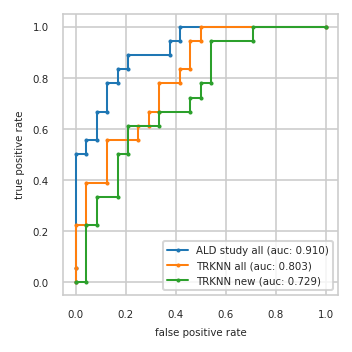

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       TRKNN all       TRKNN new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.500     0.000 0.222     0.042 0.222
3          0.042 0.500     0.042 0.222     0.083 0.222
4          0.042 0.556     0.042 0.389     0.083 0.333
5          0.083 0.556     0.125 0.389     0.167 0.333
6          0.083 0.667     0.125 0.556     0.167 0.500
7          0.125 0.667     0.250 0.556     0.208 0.500
8          0.125 0.778     0.250 0.611     0.208 0.611
9          0.167 0.778     0.292 0.611     0.333 0.611
10         0.167 0.833     0.292 0.667     0.333 0.667
11         0.208 0.833     0.333 0.667     0.458 0.667
12         0.208 0.889     0.333 0.778     0.458 0.722
13         0.375 0.889     0.417 0.778     0.500 0.722
14         0.375 0.944     0.417 0.833     0.500 0.778
15         0.417 0.944     0.458 0.833     0.542 0.778
16         0.417 1.000     0.458 0.944     0.542 0.944
17         1.000 1.000     0.500 0.944     0.708 0.944
18           NaN   NaN     0.500 1.000     0.708 1.000
19           NaN   NaN     1.000 1.000     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,TRKNN all,TRKNN new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P31321
1,Q8NCL4,P08670,P61088
2,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,P01011,Q14894
3,P61981,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P14174,P10909-3,Q9NUQ9
5,P04075,P61981,Q9GZT8;Q9GZT8-2
6,P00338;P00338-3,P15151-2,J3KSJ8;Q9UD71;Q9UD71-2
7,Q9Y2T3;Q9Y2T3-3,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P18428,P25189;P25189-2,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/prec_recall_curve.pdf


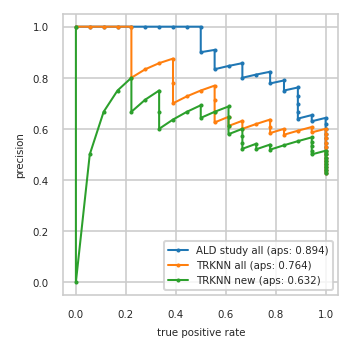

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       TRKNN all       TRKNN new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.778 0.778     0.611 0.611     0.611 0.611
25         0.824 0.778     0.647 0.611     0.647 0.611
26         0.812 0.722     0.625 0.556     0.688 0.611
27         0.800 0.667     0.667 0.556     0.667 0.556
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.667 0.444
31         0.909 0.556     0.727 0.444     0.636 0.389
32         0.900 0.500     0.700 0.389     0.600 0.333
33         1.000 0.500     0.778 0.389     0.667 0.333
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/prec_recall_curve_train.pdf


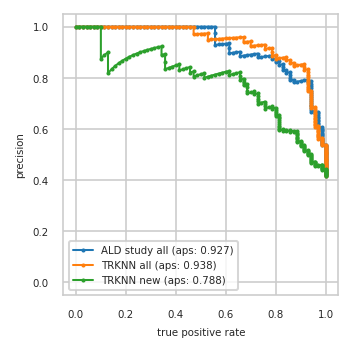

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/auc_roc_curve_train.pdf


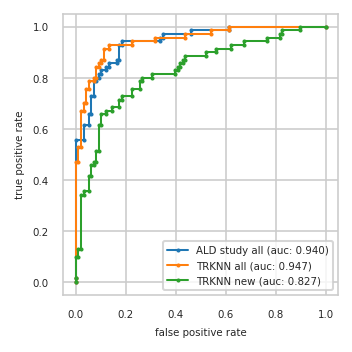

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_TRKNN all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/results_TRKNN all.pkl'),
 'results_TRKNN new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/results_TRKNN new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_TRKNN/auc_roc_curve_train.pdf')}